In [1]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 45.7 s


### Settings

Questions recive all the questions treated

In [2]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

The questions that has an answer will be used for test while another questions will be used for train.

In [3]:
train_questions, test_questions = MD.split_questions(questions)

## Question Processing

### Question Classification

Questions to train and test

In [4]:
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

Load Word2Vec model

In [7]:
%%time
w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

Wall time: 4min 5s


Training

In [8]:
%%time
classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Wall time: 1min 36s


Or Loading the model

In [ ]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Answer type is predicted for all questions

In [9]:
questions = QP.predict_answer_type(model, test_questions)

#### Testing

In [10]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(qc_y_train),'  Size test:',len(qc_y_test))

Size train: 1694   Size test: 655


Accuracy: 0.906870229008
F1 Score: 0.900186476829


<IPython.core.display.Javascript object>


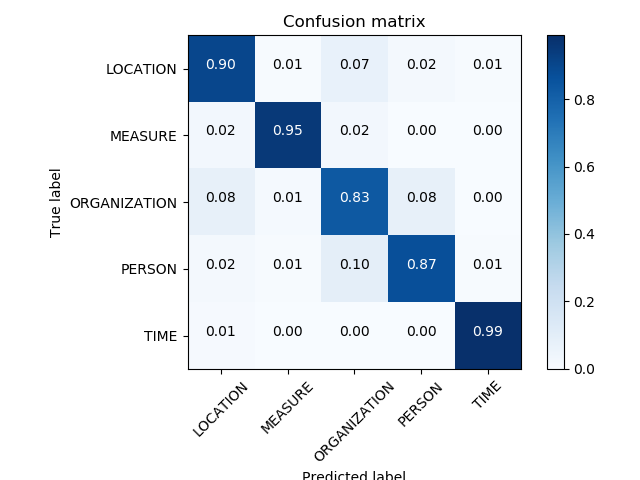

In [15]:
%matplotlib notebook
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

### Query Formulation

All test questions will recive the query for IR module. 

In [43]:
test_questions = QP.queryFormulation(test_questions)

## Information Retrieval

### Document Retrieval

In [17]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [19]:
ir.start(reset=False)

In [44]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

Wall time: 11.2 s


#### Testing

In [45]:
import numpy as np

precisions = []
recalls = []
f_scores = []
b = 0.5
for question in test_questions:
    relevants = []
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            relevants.append(answer['doc'])
    total_relevants = len(relevants)
    if total_relevants == 0:
        continue
    relevents_retrieval = 0
    for retrieval in question['retrieval']:
        if retrieval in relevants:
            relevents_retrieval += 1
    if len(question['retrieval']) == 0:
           # print(question['query'])
            precision = 0
    else:
        precision = relevents_retrieval / len(question['retrieval'])
    precisions.append(precision)
    recall = relevents_retrieval / total_relevants
    recalls.append(recall)
    if (precision + recall) == 0:
        f_score = 0
    else:
        f_score = 2 * ((precision * recall) / (precision + recall))
    f_scores.append(f_score)

print('Precision: '+str(np.mean(precisions)))
print('Recall: '+str(np.mean(recalls)))
print('F-Score: '+str(np.mean(f_scores)))

Precision: 0.0606132075472
Recall: 0.494805705301
F-Score: 0.105535754017


In [46]:
test_questions[0]['question']

'Em que cidade se encontra a prisão de San Vittore?'

In [47]:
test_questions[0]['query']

'text:Em text:que text:cidade text:se text:encontra text:a text:prisão text:de text:San text:Vittore'

In [48]:
test_questions[0]['answers']

[{'answer': '\nMilão\n', 'doc': 'PUBLICO-19940724-039', 'n': '2'}]

## Answer Processing

### Named Entity Recognition

In [22]:
import named_entity_recognition as NER

model_ner = NER.train()

#### Testing

In [23]:
NER.predict(model_ner, u'A cidade de Porto Seguro')

[['O', 'O', 'O', 'LOCAL-B', 'LOCAL-I']]

### Answer Extraction

In [49]:
test_questions = AP.answer_candidates(test_questions, QP, ir, NER, model_ner)

[ . . . . . . . . . . ]


In [50]:
test_questions = AP.finals_answer(test_questions)

#### Testing

Check if the answer_candidates have the right answer

In [51]:
AP.test_answer_candidates(test_questions)

655 / 368
Accuracy: 56.183 %


## Final Evaluate

In [52]:
for i in range(len(test_questions)):
    print(test_questions[i]['question'])
    print(test_questions[i]['final_answer'])
    for answer in test_questions[i]['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')
    print('\n')

Em que cidade se encontra a prisão de San Vittore?
Itália
Milão | 

Onde era o campo de concentração de Auschwitz?
Polónia.
Sul da Polónia | Polónia | Sudoeste da Polónia ocupada | 

Quem foi o autor de Mein Kampf?
presidente Bill Clinton
Adolf Hitler | 

Qual é a capital da Rússia?
Budinovsk,
Moscovo | 

Quem foi o primeiro presidente dos Estados Unidos?
Lyndon Johnson
George Washington | 

Com quem se casou Michael Jackson?
Michael Jackson
Lisa Marie Presley | 

Quantos crimes são atribuídos ao Monstro de Florença?
16
16 assassinatos | 

Quantos desempregados há na Europa?
2,8
23 milhões | 

Quantas religiões monoteístas há no mundo?
14
três | 

Nomeie uma pessoa acusada de pedofilia.
Tailândia.
Brendan Smyth | Hans Hermann Groer | 

Quem escreveu Ulisses?
«Ulisses». «Quando
James Joyce | 

Onde se situa o CERN?
França
Genebra | 

Em que dia calha o solstício de verão?
22
aproximadamente a 21 de Junho | 

Onde fica o Museu do Hermitage?
Borgonha
São Petersburgo | 

Qual o nome da mul

Quando estreia o filme Lisbon Story?
24 horas
16 de Dezembro | 

Quando foi aprovada a Declaração Universal dos Direitos do Homem?
23.
1948 | 

Quando morreu Salvador Allende?
1973
11 de Setembro de 1973 | 

Quando morreu Simão Bolívar?
Fevereiro de 1992
17 de Dezembro de 1830 | 

Em que dia se comemora a independência do Brasil?
7 de Setembro,
7 de Setembro | 

Quando se tornou A Portuguesa hino nacional?
26 de Abril de 74,
5 de Outubro de 1910 | 

Em que ano ocorreu o 25 de Abril?
28 de Maio de 1926,
1974 | 

Que país é campeão do mundo de futebol?
Colômbia.
Brasil | 

Onde é que caiu um meteorito em 1908?
Amazónia
Sibéria | Sibéria | 

Quantos capacetes azuis holandeses havia em Srebrenica, na Bósnia, em Julho de 1995?
cerca de 30 mil
400 | 

Indique um fabricante de automóveis alemão.
Greenpeace
BMW | 

Que partido foi fundado por Andrei Brejnev?
Rússia
NIL | 

Quem recebeu o Prémio Nobel da Paz em 1989?
Wei Jingsheng,
Dalai Lama | Tenzin | Dalai Lama | 

Quem é o primeiro-ministro

Que quantidade de peixe come uma foca por dia?
10 anos, e US$ 31.80,
20,25 quilos | 30 quilos | 25 quilos | 

Que partido regressou ao poder em Outubro de 1993?
Hospital Onassis,
PASOK | 

De que jornal é repórter Clark Kent?
Reportagem Local Lois Lane,
Daily Planet | Daily Planet | 

De que partido é líder António Guterres?
Estados Gerais
PS | Partido Socialista | Partido Socialista | 

Em que organização trabalha Luc Montagnier?
Centro Nacional da Investigação Científica (CNRS)
Instituto Pasteur | Instituto Pasteur | 

Qual a banda de Siouxie Sioux?
Reportagem Local
Banshees | 

Qual era o maior partido italiano?
Partido Democrático da Esquerda
Democracia Cristã | 

Qual o partido-irmão da CDU na Baviera?
50 por cento
União Social Cristã ( CSU ) | 

Que partido fundou Manfred Brunner?
Tratado de União Europeia,
Liga dos Cidadãos Livres ( BFB ) | 

Que time se mudou para Salt Lake City?
Hakeem,
New Orleans Jazz | 

Quem assassinou Salvo Lima?
Giovanni Falcone,
Máfia | 

Quem é preside

França | 

Onde ocorreram casos de febre aftosa?
São Jorge do Patrocínio,
Grécia | Catolé do Rocha , Brejo do Cruz , São Bento , Paulista , Belém do Brejo do Cruz e Brejo dos Santos | interior da Paraíba | São Jorge do Patrocínio , no Paraná | 

Quando aderirão à União Europeia a Áustria, a Suécia e a Finlândia?
1 de Janeiro de 1995
1 de Janeiro de 1995 | 

Que estúdio produziu o filme Toy Story?
Andy.Para
Pixar | Pixar | estúdios Disney | 

Quem era o capitão do Ajax em 1994?
Ajax, Danny Blind,
Danny Blind | 

Em que cidade é que Nietzsche escreveu Ecce Homo?
Rõcken,
NIL | 

Quando viveu Ludwig Wittgenstein?
29 de Abril de 1951, Wittgenstein
1889-1951 | 

Quem foi votado o futebolista do ano na Bélgica em 1995?
«France Football»
Marc Degryse | 

Onde é a nova sede da Nederlandse Gasunie?
Alemanha (Bundesbank)
NIL | 

Em que museu foi exibida em 1994 uma exposição sobre Mondriaan?
Washington
NIL | 

Quando foram as Antilhas Holandesas legalmente equiparadas aos Países Baixos?
1991,
NIL

Quantos são eles?
6,8 por cento
quatro | 

Qual deles fica na Europa?
Mais 3.000
 | 

Em que zona de Espanha nasce o rio Douro?
Douro
na província de Sória, nos picos da Serra de Urbião (Sierra de Urbión) | 

Onde fica o parque Eduardo VII?
Pelouro do Ambiente
centro de Lisboa | 

Quantos focos tem uma elipse?
1 e 2
dois | 

Quantos pontos vale um ensaio no râguebi?
35
cinco | 

Diga uma escritora sarda.
França, Michèle Sarde
Grazia Deledda | 

Qual a freguesia mais populosa de Évora?
Queluz (Sintra)
Malagueira | 

Que equipa é treinada por Fernando Santos?
Portugal,
Sport Lisboa e Benfica | 

Que equipa era treinada por Fernando Santos em 1994?
Portugal,
Estoril | 

Em que estado brasileiro fica Faro?
Norte
Pará | 

Em que época é que o FC Porto ganhou a Liga dos Campeões?
Porto
2003-2004 | 

Que percentagem dos finlandeses fala sueco?
6,5 milhões
5,5% | 

Quando é que F.H. Cardoso tomou posse como presidente?
15
em 1 de janeiro de 1995 | 

Que profundidade atinge a Fossa das Marianas

Em que ano foi construída a sinagoga de Curação?
1888,
1732 | 

Com que idade o Mequinho foi campeão brasileiro de xadrez?
14
13 anos | 

Quem dirigiu o Japão durante a Segunda Guerra Mundial?
Nagisa Oshima
Hirohito | 

Quantas repúblicas formavam a URSS?
15
15 | 

Em que país fica a Ossétia do Norte?
Slepsovsk,
Federação Russa | 

E a Ossétia do Sul?
ministério da Defesa,
Geórgia | 

Qual a largura do Canal da Mancha no seu ponto mais estreito?
2000 CV, 128 metros
34 km | 

Quem criou Descobridores de Catan?
Adriano da Silva Varela,
Klaus Teuber | 

Quem é o santo patrono dos cervejeiros?
Dario Castaño,
Arnulfo de Metz | 

E do pão?
L. A. (Alcobaça )Há
São Caetano di Thiène | 

Qual a envergadura de um milhafre-preto?
80,
135-155cm | 

Quanto é que ele pesa?
6.
cerca de 1kg | 

Quantas províncias tem a Ucrânia?
19 de abril,
24 | 

Que partido foi fundado por Amílcar Cabral?
Governo
PAIGC | 

Quem é o dono do Chelsea?
Manchester United
Roman Abramovich | 

Quantos habitantes tinha Berl

In [55]:
total = len(test_questions)
right = 0
for question in test_questions:
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = test_questions[i]['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')

655 / 11
Accuracy: 1.679 %


## Util

In [ ]:
ir.stop()

In [42]:
import importlib
importlib.reload(QP)
#raise IpyExit

<module 'question_processing' from 'C:\\Users\\Eduardo\\UFRGS\\QA\\qa-chave\\question_processing.py'>